# Agenda:

The steps to be performed for the first task are given below.

    Exploratory data analysis

    Data cleaning

    Text preprocessing

    Feature extraction: In order to extract features from the text data, you may choose from any of the methods, including bag-of-words, TF-IDF vectorization or word embedding.

    Training a text classification model: You need to build at least three ML models. You then need to analyse the performance of each of these models and choose the best model. At least three out of the following four models need to be built (Do not forget, if required, handle the class imbalance and perform hyperparameter tuning.). 
    1. Logistic regression
    2. Random forest
    3. XGBoost
    4. Naive Bayes
    
    Building a recommendation system
    1. User-based recommendation system
    2. Item-based recommendation system
    
    Improving the recommendations using the sentiment analysis model
    
    Deployment of this end to end project with a user interface
    
    


# Let's start with the EDA

In [733]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [734]:
import warnings
warnings.filterwarnings("ignore")

In [735]:
#####Using pyspark for sql

# import pyspark
# import findspark

# from pyspark.sql import SparkSession, HiveContext, SQLContext
# from pyspark.sql.functions import expr

In [736]:
#from pyspark.sql.functions import isnull, col

In [737]:
#spark = SparkSession.builder.appName("Sentiment_analysis").master("local[*]").getOrCreate()

In [738]:
##### Importing the dataset

df = pd.read_csv("sample30.csv")

In [739]:
df.shape

(30000, 15)

In [740]:
# sqlContext = SQLContext(spark)

# df_spark = sqlContext.read.format('com.databricks.spark.csv')\
#     .options(header='true', inferschema='true', delimiter=',', escapeQuotes= True)\
#     .option("quote", "\"")\
#     .option("escape", "\"")\
#     .load("sample30 (1).csv")

In [741]:
pd.set_option("display.max_colwidth", -1)

## Let's plot few graphs

### Sentiment distribution

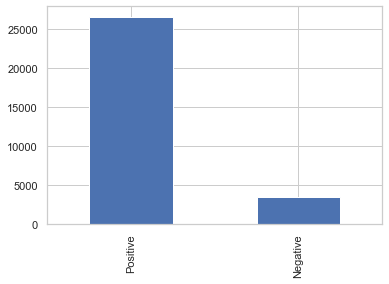

In [742]:
df.user_sentiment.value_counts().plot.bar()
plt.show()

#### Inferences:
    1. There are very few negative reviews. It's unbalanced

Total number of distinct users are 24914


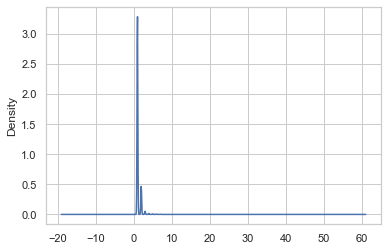

In [743]:
##### Total number of unique users

user_dtls = df.reviews_username.value_counts()
print("Total number of distinct users are %d" %len(user_dtls.keys()))
user_dtls.plot.density()
plt.show()

Total number of distinct products are 271


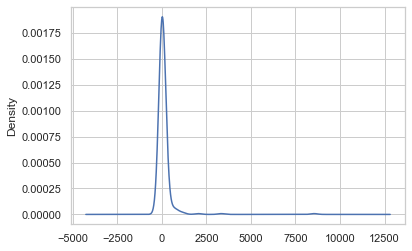

In [744]:
#####Number of distinct products:

product_dtls = df.name.value_counts()
print("Total number of distinct products are %d" %len(product_dtls.keys()))
product_dtls.plot.density()
plt.show()

### Let's analyze geographically

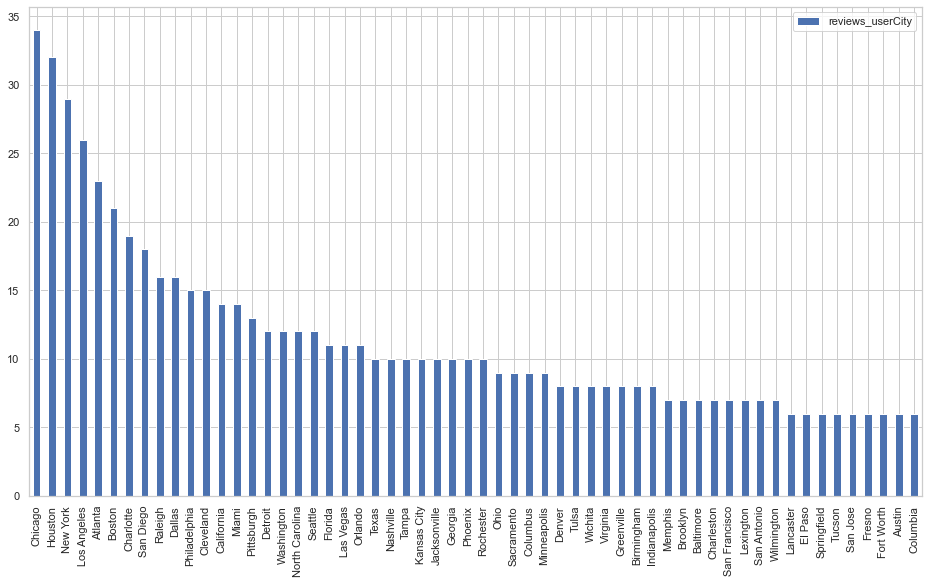

In [745]:
##### By City

city_desc = df.reviews_userCity.value_counts()
city_desc = pd.DataFrame(city_desc)
city_desc[city_desc.reviews_userCity > 5].plot.bar(figsize = (16, 9))

plt.show()

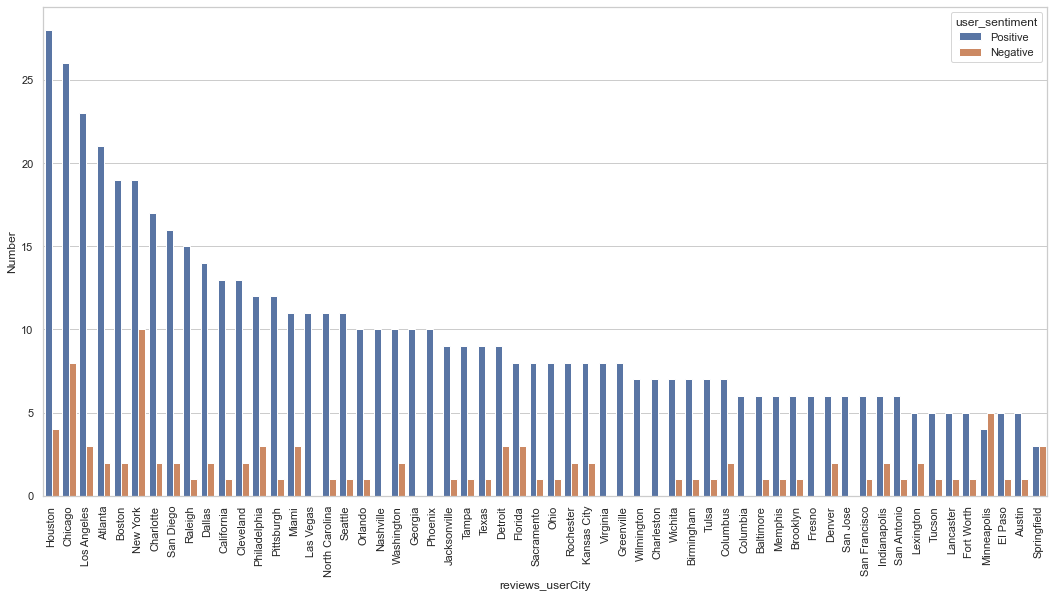

In [746]:
##### Lets check if city contributes towards the sentiment.
fig = plt.figure(figsize=(18, 9))
imp_cities = list(city_desc[city_desc.reviews_userCity > 5].index)

city_reviews = pd.DataFrame(df[df["reviews_userCity"].isin(imp_cities)][["reviews_userCity", 
                                             "user_sentiment"]].value_counts(), columns = ["Number"]).reset_index()

sns.barplot(data = city_reviews, x = "reviews_userCity", y = "Number", hue = "user_sentiment",)
plt.xticks(rotation = '90')
plt.show()

### Let's inspect the categories

In [747]:
#####Finding categroies with atleast 1 negative review (Creating a spark temp view)

# df_spark.createOrReplaceTempView("reviews_temp")


In [748]:
# spark.sql('''
# with X as (
#     select brand,user_sentiment, count(user_sentiment) as count_reviews from reviews_temp
#         group by brand, user_sentiment
#     ), Y as(
#         select brand, case when user_sentiment = "Positive" then count_reviews 
#                         else "0"
#                         end as Positive_count,
#                         case when user_sentiment = "Negative" then count_reviews 
#                         else "0"
#                         end as Negative_count 
#             from X 
#             order by brand
#             ), Z as 
#             (select brand, int(sum(Positive_count)) as sum_p, int(sum(Negative_count)) as sum_n
#             from Y
#             group by brand)
#             select * from Z 
#             where sum_n > sum_p
# ''').show()

### Inference:
    1. Above few brands have more negative reviews than positive

# Data Clean ups

### Let's check for nulls now

In [749]:
df.isna().sum()

id                      0    
brand                   0    
categories              0    
manufacturer            141  
name                    0    
reviews_date            46   
reviews_didPurchase     14068
reviews_doRecommend     2570 
reviews_rating          0    
reviews_text            0    
reviews_title           190  
reviews_userCity        28071
reviews_userProvince    29830
reviews_username        63   
user_sentiment          1    
dtype: int64

User Sentiment has a null value. We need to remove it as it is our target variable

In [750]:
df[df['user_sentiment'].isna()]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),2014-11-07T00:00:00.000Z,NaN,True,5,my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy,a super hit with my children. they loved it!!??,NaN,mamad,7.87E+11,NaN


In [751]:
df[(df['id'] == "AVpfRTh1ilAPnD_xYic2") & (df['reviews_userProvince'] == 'mamad')]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),2014-11-07T00:00:00.000Z,NaN,True,5,my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy,a super hit with my children. they loved it!!??,NaN,mamad,7.87E+11,NaN


In [752]:
df_1 = df.copy()

In [753]:
df_1.drop(index = 28354, inplace = True)

In [754]:
round((df_1.isna().sum()/len(df_1))*100, 2)

id                      0.00 
brand                   0.00 
categories              0.00 
manufacturer            0.47 
name                    0.00 
reviews_date            0.15 
reviews_didPurchase     46.89
reviews_doRecommend     8.57 
reviews_rating          0.00 
reviews_text            0.00 
reviews_title           0.63 
reviews_userCity        93.57
reviews_userProvince    99.44
reviews_username        0.21 
user_sentiment          0.00 
dtype: float64

#### Inference:

Almost all the values are missing in reviews_userCity and reviews_userProvince. Also there are more than 40% null values in reviews_didPurchase. Hence we can safely drop these columns

In [755]:
df_1.drop(['reviews_userCity', 'reviews_userProvince', 'reviews_didPurchase'], axis = 1, inplace = True)

In [756]:
round((df_1.isna().sum()/len(df_1))*100, 2)

id                     0.00
brand                  0.00
categories             0.00
manufacturer           0.47
name                   0.00
reviews_date           0.15
reviews_doRecommend    8.57
reviews_rating         0.00
reviews_text           0.00
reviews_title          0.63
reviews_username       0.21
user_sentiment         0.00
dtype: float64

In [757]:
###### reviews_doRecommend has null values for ~2000+ rows. Let's see if we can impute these values

df_1[df_1.reviews_doRecommend.isna()]

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor.,Good,dorothy w,Positive
16,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-29T00:00:00.000Z,NaN,1,I bought this product to spice things up with my fianc and it didn't do anything! No passion. Will not buy again,Was so disappointed!!,beccagrl532,Negative
23,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2017-08-15T00:00:00.000Z,NaN,5,Loved This review was collected as part of a promotion.,Loved,ashley a,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...
29842,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,2016-12-31T00:00:00.000Z,NaN,5,This conditioner smells amazing! It also leaves your hair so much softer than when you started. My hair felt freah and clean after using it. I received this free from Influenster to test and will buy now as well! This review was collected as part of a promotion.,So smooth,wintereve,Positive
29883,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,2017-01-13T00:00:00.000Z,NaN,5,amazing doesn't even begin to describe this conditioner. it was received free from influenster and it is one of the best conditioners i've ever used. This review was collected as part of a promotion.,wonderful,lisabl,Positive
29899,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,2017-01-14T00:00:00.000Z,NaN,5,I forgot how much I loved L'Oral conditioners. Just overall made my hair soft without being oily. Was able to brush through my hair and get all the knots out. This review was collected as part of a promotion.,Super soft hair,bethst,Positive
29909,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,2017-01-11T00:00:00.000Z,NaN,5,I received this product free for complimentary testing purposes and by far is my favorite conditioner. It is super rich and flows through my hai

#### We can assume that if the user sentiment is positive, chances are that product is going to get recommended. Hence, we'll impute accordingly

In [758]:
df_1['reviews_doRecommend'] = np.where((df_1['reviews_doRecommend'].isna()) & (df_1['reviews_rating'] >= 3), True, df_1['reviews_doRecommend'])

In [759]:
df_1['reviews_doRecommend'] = np.where((df_1['reviews_doRecommend'].isna()) & (df_1['reviews_rating'] < 3), False, df_1['reviews_doRecommend'])

In [760]:
round((df_1.isna().sum()/len(df_1))*100, 2)

id                     0.00
brand                  0.00
categories             0.00
manufacturer           0.47
name                   0.00
reviews_date           0.15
reviews_doRecommend    0.00
reviews_rating         0.00
reviews_text           0.00
reviews_title          0.63
reviews_username       0.21
user_sentiment         0.00
dtype: float64

### There are records where the username is not mentioned. We simply cannot use those reviews for anything. Hence we can remove those rows.

In [761]:
df_1[df['reviews_username'].isna()].shape[0]

63

In [762]:
###Removing above mentioned 63 records

df_1.dropna(subset = ['reviews_username'], inplace = True)

In [763]:
round((df_1.isna().sum()/len(df_1))*100, 2)

id                     0.00
brand                  0.00
categories             0.00
manufacturer           0.47
name                   0.00
reviews_date           0.13
reviews_doRecommend    0.00
reviews_rating         0.00
reviews_text           0.00
reviews_title          0.63
reviews_username       0.00
user_sentiment         0.00
dtype: float64

### Let's check if there are reviews where sentiment is incorrectly mentioned

In [764]:
df_1[(df['user_sentiment'] == 'Positive') & (df['reviews_rating'] < 3) & (df['reviews_doRecommend'] == False)]['reviews_text']

9        Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [765]:
df_1[(df['user_sentiment'] == 'Negative') & (df['reviews_rating'] >= 3) & (df['reviews_doRecommend'] == True)]['reviews_text']

42       You would think it's convenient to have bubble bath and wash in the same container, but it just means you buy twice the amount... My son loves the bubbles though so no complaints.                                                                                                                                                                             
83       I would recommend this product to those who don't have the money to spend on expensive lotions daily facial products. As we all know older we get we start showing signs of our real age. Olay has products for your every day concerns and cares. I've used Olay products off on for years.                                                                    
92       It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected as part of a promotion.                                                                                                                                                     

### Above sentiment labels could mess up our prediction. Hence we should impute them with correct labels.

In [766]:
df_1['user_sentiment'] = np.where((df_1['user_sentiment'] == 'Positive') & 
(df_1['reviews_rating'] < 3) & (df_1['reviews_doRecommend'] == False), "Negative", df_1['user_sentiment'])

df_1['user_sentiment'] = np.where((df_1['user_sentiment'] == 'Negative') & 
(df_1['reviews_rating'] >= 3) & (df_1['reviews_doRecommend'] == True), "Positive", df_1['user_sentiment'])


#### For the rest of the columns containing nulls, we can impute them using mean median mode, as they are dependent on the products and users

In [767]:
### Lets check the reviews containing null reviews title

df_1[df_1['reviews_title'].isna()]

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
1239,AV1YneDPglJLPUi8IJyQ,Finish,"Household Essentials,Cleaning Supplies,Dish Detergents,Ways To Shop,Household Essentials Subscriptions,Kitchen,Dishwasher Detergent,Natural Cleaning,Glass Cleaners,Dish Detergent",Reckitt Benckiser,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",2017-11-16T08:12:30.000Z,True,5,Great quality and a great price,NaN,queen 79,Positive
1441,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Shampoo & Conditioner,Salon Hair Care,Conditioners",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",2013-11-07T00:00:00Z,True,3,Wanted to love this but it's a bit too heavy for me. I have mild psoriasis and this seemed to make it itch more?? think it's the argan oil - must be allergic.,NaN,julie,Positive
1442,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Shampoo & Conditioner,Salon Hair Care,Conditioners",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",2015-02-09T00:00:00Z,True,3,I have thick coarse hair and for me this just worked ok. It did not smooth as much as other products I have tried. It has a scent that is acceptable.,NaN,lisa,Positive
1443,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Shampoo & Conditioner,Salon Hair Care,Conditioners",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",2013-11-07T00:00:00Z,True,3,Wanted to love this but it's a bit too heavy for me. I have mild psoriasis and this seemed to make it itch moreI think it's the argan oil - must be allergic.,NaN,julie,Positive
1444,AVpe_dxlilAPnD_xSiHI,The Seaweed Bath Co.,"Personal Care,Hair Care,Conditioner,Beauty,Shampoo & Conditioner,Salon Hair Care,Conditioners",The Seaweed Bath,"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",2017-11-27T18:18:38.000Z,True,4,"I actually really enjoy this conditioner. Have tried a whole bunch, both expensive and cheap. I have thick, curly and dry hair so I'm pretty particular about what I use. Smell is nice! I used it with the Moisturizing unscented shampoo and feel like the combo of the two is keeping my hair very healthy. I've also noticed less frizz as well. I've only used it a couple times but I only wash my hair once ever 4-5 days or so. Scalp isn't greasy and hair isn't dried out. Curls aren't too frizzy either!",NaN,aland,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...
28790,AVpfvieo1cnluZ0-qdnu,L'Oreal Paris,"Personal Care,Hair Care,Styling Gel/Lotion,Beauty,Salon Hair Care,Styling Products,Conditioners",Generic,L'oreal Paris Advanced Hairstyle TXT IT Hyper-Fix Putty,2014-02-28T00:00:00Z,True,5,"I have fine hair and don't like heavy hairspray. This leaves a touchable, yet strong hold for my cropped shag style.",NaN,linny,Positive
28791,AVpfvieo1cnluZ0-qdnu,L'Oreal Paris,"Personal Care,Hair Care,Styling Gel/Lotion,Beauty,Salon Hair Care,Styling Products,Conditioners",Generic,L'oreal Paris Advanced Hairstyle TXT IT Hyper-Fix Putty,2014-09-04T00:00:00Z,True,5,I tried this product for the first time im very surprised how good it is very good hold it works for different styles !!! and a great price of course,NaN,marcos,Positive
28792,AVpfvieo1cnluZ0-qdnu,L'Oreal Paris,"Personal Care,Hair Care,Styling Gel/Lotion,Beauty,Salon Hair Care,Styling Products,Conditioners",Generic,L'oreal Paris Advanced Hairstyle TXT IT Hyper-Fix Putty,2015-04-17T00:00:00Z,True,5,"I am an African American woman who has been natural for quite some time now. I have been searching for a good holding style product. I have tried numerous gels and other pomades, only to find that none of them worked. I happened to stop at my local Walgreens store and saw this product. I was a bit skeptical because of the price in knowing how affordable it was and whether o

Let's check the most common reviews title for positive and negative reviews

In [768]:
df_1[df_1['user_sentiment'] == 'Positive']['reviews_title'].value_counts()

Great Product                     382
Great movie                       361
Clorox Wipes                      275
Great                             221
Great product                     205
                                 ... 
Excellent Folders For Tax Uses    1  
Excellent conditioner             1  
love love love clorox             1  
Jolly Time Select Popcorn         1  
Perfect For Kitchen               1  
Name: reviews_title, Length: 16947, dtype: int64

In [769]:
df_1[df_1['user_sentiment'] == 'Negative']['reviews_title'].value_counts()

Disappointed                                          14
Terrible                                              9 
Disappointing                                         9 
New Formula                                           8 
Not what I expected                                   8 
                                                     .. 
No hold, smells funny                                 1 
I don't like the new formula                          1 
Not Holding Up!                                       1 
Makes my hair soft, but does not do what it claims    1 
Big Mistake                                           1 
Name: reviews_title, Length: 1612, dtype: int64

### Let's impute reviews title accordingly

In [770]:
df_1['reviews_title'] = np.where((df_1['reviews_title'].isna()) & 
                               (df_1['user_sentiment'] == 'Positive'), "Great", df_1['reviews_title'])

df_1['reviews_title'] = np.where((df_1['reviews_title'].isna()) & 
                               (df_1['user_sentiment'] == 'Negative'), "Disappointed", df_1['reviews_title'])

In [771]:
### Let's drop manufacturer and reviews_date columns

df_1.drop(['manufacturer', 'reviews_date'], axis = 1, inplace = True)

In [772]:
df_1.reset_index(drop=True, inplace=True)

In [773]:
df_1.shape

(29936, 10)

## We'll export this cleaned up data set for further use

In [774]:
data_export = df_1.copy()

### We lost 64 records and 5 columns in total

# Feature Extraction/ EDA

## Let's analyze the reviews

In [775]:
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()

In [776]:
!pip install wordcloud

zsh:1: command not found: pip


In [777]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [778]:
from nltk.tokenize import word_tokenize

In [779]:
### Let's add a column for reviews length

df_1['reviews_length'] = df_1['reviews_text'].apply(lambda x: len(str.split(x, " ")))

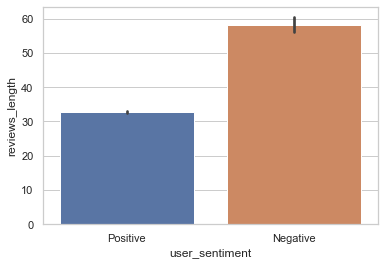

In [780]:
sns.barplot(x = df_1["user_sentiment"], y = df_1["reviews_length"], estimator= np.mean)
plt.show()

#### Negative reviews are generally longer than positive reviews. May be that's because users are generally emotionally distressed while writing negative reviews and tends to describe the situation in more details.

In [781]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [782]:
#!pip install contractions

In [783]:
#!pip install textblob

In [784]:
import contractions

In [785]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

stem = PorterStemmer()
lemma = WordNetLemmatizer()

In [786]:
import re

### Let's remove the contactions

In [787]:
df_1['reviews_text'] = df_1['reviews_text'].apply(lambda x: " ".join(
    [contractions.fix(i) for i in str.split(x)]))

### Let's check how many distinct words are there

In [788]:
df_1['Feature'] = df_1.apply(lambda x: x['reviews_text'] + " " + 
                                                 x['reviews_title'], axis=1)

In [789]:
pattern = re.compile("[0-9]+|[$|\.]|www\.\S+")
pattern_2 = re.compile("|[^\w\s]")

In [790]:
#pattern = re.compile("([1-9]+[|$|\.]$)|[\.|!|..|,|$|']")
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
df_1['tokenized_reviews'] = df_1['Feature'].apply(lambda x: " ".join([str.lower(lemma.lemmatize(i, get_wordnet_pos(i))) for i in 
                                                                  nltk.word_tokenize(re.sub(pattern_2, "", re.sub(pattern, "", x)))]))

In [791]:
def normalize(sentence):
    import re
    from textblob import TextBlob
    from textblob import Word
    rx = re.compile(r'([^\W\d_])\1{2,}')
    return re.sub(r'[^\W\d_]+',lambda x: Word(rx.sub(r'\1\1', x.group())).correct() if rx.search(x.group()) else x.group(), sentence) 

In [792]:
####Normalizing words:

df_1['tokenized_reviews'] = df_1['tokenized_reviews'].apply(lambda x: normalize(x))

In [793]:
df_1

,id,brand,categories,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_length,Feature,tokenized_reviews
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Pink Friday: Roman Reloaded Re-Up (w/dvd),True,5,i love this album. it is very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,Positive,41,i love this album. it is very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy. Just Awesome,i love this album it be very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it star rating all the way her metaphor be just crazy just awesome
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg Organic Cinnamon Toast Rice Cakes,True,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,Positive,11,Good flavor. This review was collected as part of a promotion. Good,good flavor this review be collect a part of a promotion good
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg Organic Cinnamon Toast Rice Cakes,True,5,Good flavor.,Good,dorothy w,Positive,2,Good flavor. Good,good flavor good
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y Love Sensuality Pleasure Gel,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it did not even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I am disappointed that I paid as much as I did for a lube that I will not use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,rebecca,Negative,124,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it did not even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I am disappointed that I paid as much as I did for a lube that I will not use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess. Disappointed",i read through the review on here before look in to buying one of the couple lubricant and be ultimately disappointed that it do not even live up to the review i have read for starter neither my boyfriend nor i could notice any sort of enhance or captivate sensation what we do notice however be the messy consistency that be reminiscent of a more liquidy vaseline it be difficult to clean up and be not a pleasant especially since it lack the captivate sensation we have both be expect i be disappointed that i paid a much a i do for a lube that i will not use again when i could just use their normal personal lubricant for less money and less mess disappointed
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,M

In [794]:
word_list = list(set([str.lower(i) for n in df_1['tokenized_reviews'] for i in str.split(n)]))

In [795]:
positive=[]
c= df_1[df_1["user_sentiment"] == "Positive"]['tokenized_reviews']
positive=c.values.tolist()
positive_l=[str.lower(word) for i in positive for word in str.split(i, " ") if word not in [".",",","!"]]

In [796]:
negative=[]
c= df_1[df_1["user_sentiment"] == "Negative"]['tokenized_reviews']
negative=c.values.tolist()
negative_l=[str.lower(word) for i in negative for word in str.split(i, " ") if word not in [".",",","!"]]

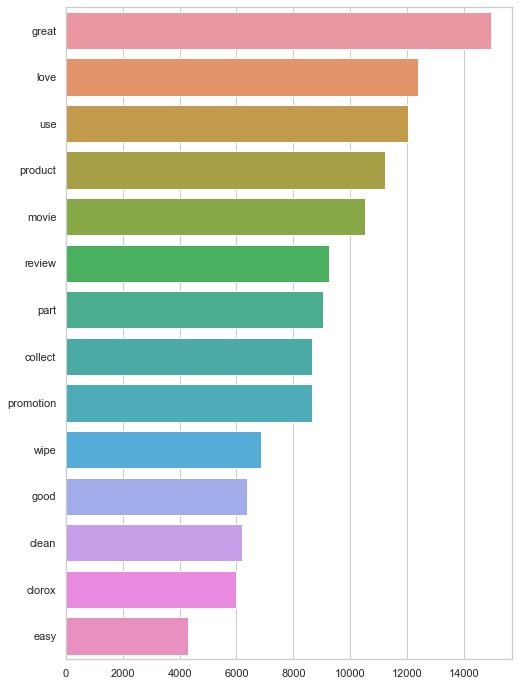

In [797]:
### Let's check the most common words for positive reviews:
import collections
from collections import Counter
fig = plt.figure(figsize = (8, 12))
counter=Counter(positive_l)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (str.lower(word) not in stopwords):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)
plt.show()

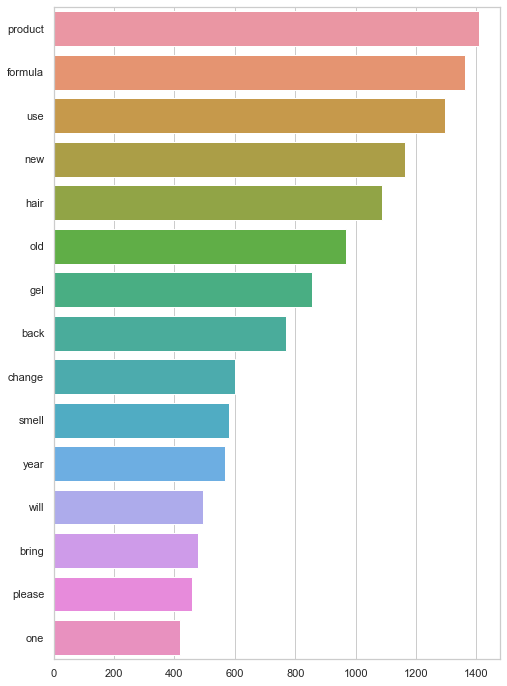

In [798]:
### Let's check the most common words for negative reviews:
import collections
from collections import Counter
fig = plt.figure(figsize = (8, 12))
counter=Counter(negative_l)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (str.lower(word) not in stopwords):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)
plt.show()

In [799]:
### Lets check word cloud for reviews

def plot_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words= 100,
        max_font_size=30,
        scale=3,
        random_state=1, )
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()


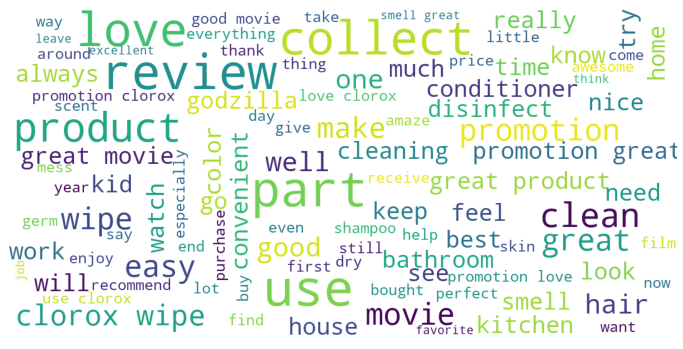

In [800]:
combined_positive = ""
combined_positive = " ".join(positive_l)+" "
plot_wordcloud(combined_positive)

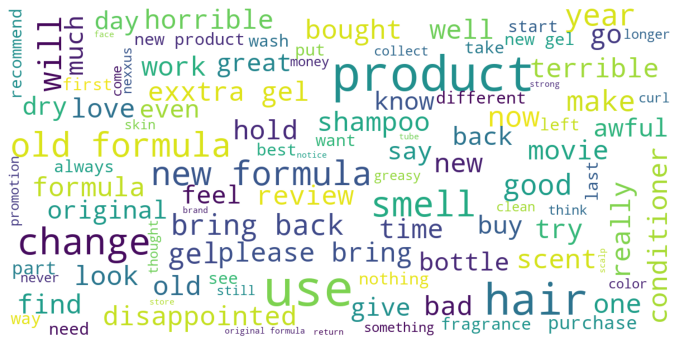

In [801]:
combined_negative = ""
combined_negative = " ".join(negative_l)+" "
plot_wordcloud(combined_negative)

#### List of all reviews

# Modelling

## Preparing train and test data

In [802]:
# lst = [df_1, df]
# del lst

In [803]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [804]:
df_1['sentiment_num'] = df_1['user_sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)

In [805]:
X = df_1.drop(['id','user_sentiment', 'sentiment_num'], axis = 1)

In [806]:
y = df_1['sentiment_num']

In [807]:
print(X.shape)
print(y.shape)

(29936, 11)
(29936,)


In [808]:
###For scalling the variables
from sklearn.preprocessing import MinMaxScaler

In [809]:
from sklearn.model_selection import train_test_split

In [810]:
tfv = TfidfVectorizer(max_features=600, 
            strip_accents='unicode', analyzer='word', binary = True,
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

In [811]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [812]:
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [813]:
(y_train.value_counts())/len(y_train)

1    0.939108
0    0.060892
Name: sentiment_num, dtype: float64

In [814]:
(y_train.value_counts())/len(y_train)

1    0.939108
0    0.060892
Name: sentiment_num, dtype: float64

In [815]:
l_train = list(X_train['tokenized_reviews'])

In [816]:
b = tfv.fit_transform(l_train)

In [817]:
data_train = pd.DataFrame(b.toarray(), columns = tfv.get_feature_names_out())

In [818]:
data_train.reset_index(drop = True, inplace = True)

In [819]:
X_train = pd.concat([X_train[['reviews_length']], data_train], axis = 1)

In [820]:
l_test = list(X_test['tokenized_reviews'])
b = tfv.transform(l_test)
data_test = pd.DataFrame(b.toarray(), columns = tfv.get_feature_names_out())
data_test.reset_index(drop = True, inplace = True)
X_test = pd.concat([X_test[['reviews_length']], data_test], axis = 1)

In [821]:
print(X_train.shape)
print(X_test.shape)

(20955, 601)
(8981, 601)


In [930]:
scaler_m = MinMaxScaler()
X_train_scaled = scaler_m.fit_transform(X_train)

In [931]:
X_test_scaled = scaler_m.transform(X_test)

In [932]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

(20955, 601)
(8981, 601)
(39358,)
(8981,)


In [825]:
####Lets use SMOTE for class imbalance
counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train_scaled, y_train = sm.fit_resample(X_train_scaled, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({1: 19679, 0: 1276})
After Counter({1: 19679, 0: 19679})


# Creating Base models

In [826]:
# import required libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [827]:
from sklearn import metrics

## Logistic regression

In [828]:
###Lets check on a simple logistic regression model

lr_1 = LogisticRegression()
lr_1.fit(X_train_scaled, y_train)

LogisticRegression()

In [829]:
# predict churn on test data
y_pred = lr_1.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = lr_1.predict_proba(X_test_scaled)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[ 447  100]
 [ 546 7888]]
Sensitivity: 	0.94
Specificity: 	0.82
AUC:    	 0.96


## Model is overfitted. Let's reduce dimensions

In [830]:
from sklearn.decomposition import PCA, IncrementalPCA

In [831]:
pca = PCA(random_state=42)
pca.fit(X_train_scaled)

PCA(random_state=42)

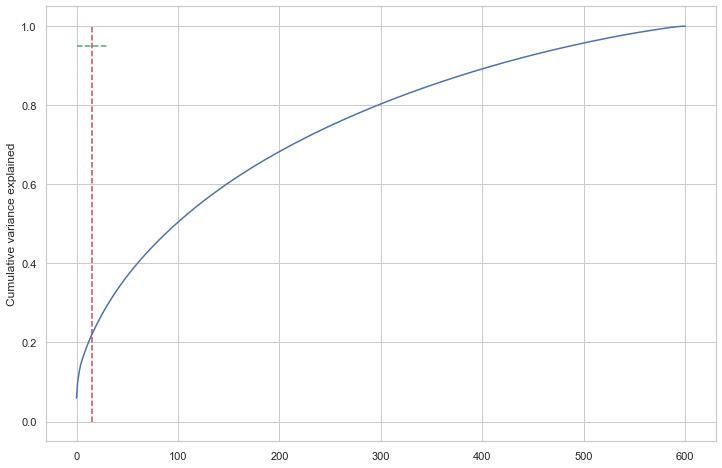

In [832]:

var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[12,8])
plt.vlines(x=15, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

### 450 can be a safe cutoff. Let's use it

In [833]:
pcafinal = IncrementalPCA(n_components=450)
X_train_PCA = pcafinal.fit_transform(X_train_scaled)
X_test_PCA = pcafinal.transform(X_test_scaled)
print(X_train_PCA.shape)
print(X_test_PCA.shape)

(39358, 450)
(8981, 450)


In [834]:
lr_2 = LogisticRegression(random_state=42, max_iter=100,solver='liblinear', class_weight="balanced")
lr_2.fit(X_train_PCA, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [835]:
from sklearn import metrics
preds = lr_2.predict_proba(X_test_PCA)
tpr, tpr, thresholds = metrics.roc_curve(y_test,preds[:,1])


accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(preds[:,1]>thres,1,0)
    # Apply desired utility function to y_preds, for example accuracy.
    sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
    accuracy_ls.append(specificity)

In [836]:
cutoff_df = pd.DataFrame(zip(accuracy_ls, thresholds), columns = ["Specificity", "Cutoff"])
cutoff_df[cutoff_df["Specificity"] > 0.98]

,Specificity,Cutoff
0,1.000000,2.000000
1,1.000000,1.000000
2,1.000000,0.999999
3,1.000000,0.999999
4,1.000000,0.999998
...,...,...
281,0.981718,0.976540
282,0.981718,0.975415
283,0.981718,0.975413
284,0.981718,0.974985


In [837]:
THRESHOLD = 0.80
y_pred = np.where(lr_2.predict_proba(X_test_PCA)[:,1] > THRESHOLD, 1, 0)
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = lr_2.predict_proba(X_test_PCA)[:, 1]
print("AUC:    \t", roc_auc_score(y_test, y_pred_prob))

[[ 505   42]
 [1470 6964]]
Sensitivity: 	0.83
Specificity: 	0.92
AUC:    	 0.9535815032650553


In [838]:
# predict sentiment on test data
y_pred = lr_2.predict(X_test_PCA)

cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = lr_2.predict_proba(X_test_PCA)[:, 1]
print("AUC:    \t", roc_auc_score(y_test, y_pred_prob))

[[ 455   92]
 [ 678 7756]]
Sensitivity: 	0.92
Specificity: 	0.83
AUC:    	 0.9535815032650553


### Now let's use it in a pipeline

In [839]:
#######Create pipeline#########

pca = PCA()
logistic = LogisticRegression()
steps = [("pca", pca),
         ("logistic", logistic)
        ]
pca_logistic = Pipeline(steps)
params = {'pca__n_components': [350, 400, 450], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5], 'logistic__max_iter': [100, 200, 300]}

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
model_lr = RandomizedSearchCV(estimator=pca_logistic, cv=folds, param_distributions = params,
                           scoring='roc_auc', n_jobs=7, verbose=10)

In [840]:
model_lr.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('logistic',
                                              LogisticRegression())]),
                   n_jobs=7,
                   param_distributions={'logistic__C': [0.1, 0.5, 1, 2, 3, 4,
                                                        5],
                                        'logistic__max_iter': [100, 200, 300],
                                        'pca__n_components': [350, 400, 450]},
                   scoring='roc_auc', verbose=10)

In [841]:
model_lr.best_score_

0.9842271224294186

In [842]:
estimator = model_lr.best_estimator_

In [843]:
estimator

Pipeline(steps=[('pca', PCA(n_components=450)),
                ('logistic', LogisticRegression(C=3, max_iter=300))])

In [844]:
# predict sentiment on test data
y_pred = estimator.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = estimator.predict_proba(X_test_scaled)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[ 444  103]
 [ 626 7808]]
Sensitivity: 	0.93
Specificity: 	0.81
AUC:    	 0.95


### Using Random Forest

In [845]:
#######Create pipeline#########

rf = RandomForestClassifier()
params = {'n_estimators': list(range(100, 1000, 150)), 
          'max_depth': list(range(10, 150, 30)),
         'min_samples_leaf': list(range(1, 15, 2))}

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
model_rf = RandomizedSearchCV(estimator=rf, cv=folds, param_distributions = params,
                           scoring='roc_auc', n_jobs=7, verbose=10)

In [846]:
model_rf.fit(X_train_PCA, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_jobs=7,
                   param_distributions={'max_depth': [10, 40, 70, 100, 130],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13],
                                        'n_estimators': [100, 250, 400, 550,
                                                         700, 850]},
                   scoring='roc_auc', verbose=10)

In [847]:
model_rf.best_score_

0.9995776571396645

In [848]:
model_rf.best_params_

{'n_estimators': 250, 'min_samples_leaf': 1, 'max_depth': 70}

In [849]:
estimator_rf = model_rf.best_estimator_

In [850]:
# predict sentiment on test data
y_pred = estimator_rf.predict(X_test_PCA)

cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = estimator_rf.predict_proba(X_test_PCA)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[ 233  314]
 [  39 8395]]
Sensitivity: 	1.0
Specificity: 	0.43
AUC:    	 0.93


### Using Naive Bias

In [851]:
from sklearn.naive_bayes import MultinomialNB

In [852]:
mnb = MultinomialNB(alpha=1.0)
mnb.fit(X_train_scaled, y_train)

MultinomialNB()

In [853]:
# predict sentiment on test data
y_pred = mnb.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = mnb.predict_proba(X_test_scaled)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[ 434  113]
 [ 836 7598]]
Sensitivity: 	0.9
Specificity: 	0.79
AUC:    	 0.94


### Out of all the estimators, logistic regression model seems to be performing the best, hence we'll convert it to pickle file

In [854]:
import pickle

In [855]:
def save_object(obj, filename):
    filename = "pickle/"+filename+'.pkl'
    pickle.dump(obj, open(filename, 'wb'))

In [856]:
save_object(data_export, "data_export")

In [933]:
save_object(tfv, "tfIDF")
save_object(scaler_m, "scaler")

In [858]:
save_object(pcafinal, "pca")

In [859]:
save_object(lr_2, "sentimentAnalysisModelLogisticRegression")

## Recommendation System

We'll use Approaches to develop Recommendation System -

Here we are going to try with 2 of the Colloboarative filtering techniques:
1. User-User Based Approach
2. Item-Item Based Approach

In [860]:
df_recommendation = df_1[["id", "name", "reviews_rating", "reviews_username"]]


In [861]:
#splitting the train and test
train, test = train_test_split(df_recommendation, test_size=0.25, random_state=42)

In [862]:
print(train.shape)
print(test.shape)

(22452, 4)
(7484, 4)


In [863]:
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"

In [864]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
df_pivot = pd.pivot_table(train,index=user_column, columns = product_column, values = value_column).fillna(0)
df_pivot.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08dallas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
09mommy11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.11E+24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating dummy train and test

In [865]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [866]:
dummy_train.head()

,id,name,reviews_rating,reviews_username
27891,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),5,silvahalo
3369,AVpe5s3RLJeJML43x4eA,Pantene Pro-V Expert Collection Age Defy Conditioner,4,stacberg
20145,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,erwerw
457,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,olay53
19013,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,nicelady


In [867]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x>=1 else 1)

In [868]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(dummy_train,index=user_column, columns = product_column, values = value_column).fillna(1)
dummy_train.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
08dallas,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
09mommy11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1.11E+24,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### User similarity matrix

In [869]:
df_pivot.index.nunique()

19427

In [870]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

In [871]:
#using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

[[1.        0.        0.        ... 0.        0.9486833 0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.9486833 0.        0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]
(19427, 19427)


### Prediction User-User

In [872]:
#filtering out the user_correlation that are negatively correlated
user_correlation[user_correlation<0]=0
user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.9486833, 0.       , 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

In [873]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 1.20913332, ..., 2.9103958 , 0.        ,
        0.54410719],
       [0.        , 0.        , 3.12347524, ..., 3.00158035, 0.        ,
        0.        ],
       [0.        , 0.        , 3.12347524, ..., 3.00158035, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.88675135],
       [0.        , 0.        , 0.        , ..., 1.64034869, 0.        ,
        0.57353933],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.88675135]])

In [874]:
#since we are interested in products that are not rated by the user, we multiply with dummy train to make it zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,1.209133,13.576034,0.0,0.0,0.0,2.256552,0.440415,3.136671,...,0.449467,0.422577,0.000000,0.0,0.0,0.0,2.121320,2.910396,0.0,0.544107
01impala,0.0,0.0,3.123475,15.578925,0.0,0.0,0.0,0.000000,2.340823,2.119252,...,1.421338,0.267261,0.000000,0.0,0.0,0.0,0.000000,3.001580,0.0,0.000000
02dakota,0.0,0.0,3.123475,15.578925,0.0,0.0,0.0,0.000000,2.340823,2.119252,...,1.421338,0.267261,0.000000,0.0,0.0,0.0,0.000000,3.001580,0.0,0.000000
02deuce,0.0,0.0,3.123475,15.578925,0.0,0.0,0.0,0.000000,2.340823,2.119252,...,1.421338,0.267261,0.000000,0.0,0.0,0.0,0.000000,3.001580,0.0,0.000000
0325home,0.0,0.0,0.000000,11.344965,0.0,0.0,0.0,6.010227,6.937603,2.097953,...,0.000000,0.445435,3.535534,0.0,0.0,0.0,2.236068,0.000000,0.0,2.886751


### Find 20 recommendation for the user

In [875]:
user_input = "08dallas" 
print(user_input)

08dallas


In [876]:
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations

id
AVpfPaoqLJeJML435Xk9    24.411263
AVpfRTh1ilAPnD_xYic2    20.730190
AVpf3VOfilAPnD_xjpun    8.481302 
AVpe41TqilAPnD_xQH3d    6.582782 
AVpf0eb2LJeJML43EVSt    5.064475 
AVpfBrUZilAPnD_xTUly    4.573207 
AVpfJP1C1cnluZ0-e3Xy    3.679464 
AV1l8zRZvKc47QAVhnAv    3.535534 
AVpf5olc1cnluZ0-tPrO    3.395675 
AVpf7I3i1cnluZ0-tnL6    2.886751 
AVpf385g1cnluZ0-s0_t    2.871632 
AVpfPnrU1cnluZ0-g9rL    2.857827 
AVpe7GIELJeJML43yZfu    2.591509 
AVpf2tw1ilAPnD_xjflC    2.541278 
AVpfhxaELJeJML43-zsM    2.216211 
AVpe8xjUilAPnD_xRkxC    2.216211 
AV1Yn94nvKc47QAVgtst    1.678363 
AVpfm8yiLJeJML43AYyu    1.678363 
AV1ZSp2uglJLPUi8IQFy    1.528942 
AV1Ys0kTvKc47QAVgx1C    1.179464 
Name: 08dallas, dtype: float64

In [877]:
#display the top 20 product id, name and similarity_score 
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,24.411263
2464,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),20.730190
3315,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8.481302
9689,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),6.582782
10262,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),5.064475
10899,AVpfBrUZilAPnD_xTUly,"Coty Airspun Face Powder, Translucent Extra Coverage",4.573207
11022,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,3.679464
12585,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,3.535534
13067,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,3.395675
13196,AVpf7I3i1cnluZ0-tnL6,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,2.886751


### Evaluation User-User

In [878]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1795, 4)

In [879]:
common.head()

,id,name,reviews_rating,reviews_username
12833,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,jessica
22526,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,4,at527
21610,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,romance318
23268,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,3,countprice
21458,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,farbar


In [880]:
# convert into the user-movie matrix.
common_user_based_matrix = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85lisa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [881]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19417,19418,19419,19420,19421,19422,19423,19424,19425,19426
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0


In [882]:
user_correlation_df[user_column] = df_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19417,19418,19419,19420,19421,19422,19423,19424,19425,19426
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
01impala,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02dakota,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02deuce,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0325home,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0


In [883]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [884]:
user_correlation_df_1.shape

(1530, 19427)

In [885]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [886]:
user_correlation_df_3 = user_correlation_df_2.T

In [887]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 7.79183531, 0.        , ..., 0.        , 0.        ,
        2.29277852],
       [0.        , 0.        , 0.        , ..., 3.12347524, 0.        ,
        0.        ],
       [0.        , 1.31227896, 0.        , ..., 0.        , 0.        ,
        1.49255579],
       ...,
       [0.        , 0.        , 0.        , ..., 3.12347524, 0.        ,
        0.        ],
       [0.        , 1.86700847, 0.        , ..., 0.        , 0.        ,
        1.74077656],
       [0.        , 0.        , 0.        , ..., 3.12347524, 0.        ,
        0.        ]])

In [888]:
dummy_test = common.copy()

dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index=user_column, columns = product_column, values = value_column).fillna(0)

In [889]:
dummy_test.shape

(1530, 129)

In [890]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85lisa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [891]:
dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85lisa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [892]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [893]:
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85lisa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [894]:
#calculate RMSE

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [895]:
common_ = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)

In [896]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [897]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.0913748696192394


### Item Based Recommendation

In [898]:
df_pivot = pd.pivot_table(train,
    index=product_column,
    columns=user_column,
    values=value_column
)

df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [899]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [900]:
df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [901]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [902]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Prediction - item-item

In [903]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.00568296, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00946238],
       [0.        , 0.        , 0.        , ..., 0.00716692, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00756991]])

#### Filtering the rating only for the products not rated by the user for recommendation

In [904]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.009141,0.0,0.0,0.0,0.00000,0.000000,0.005833,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.019346,0.005683,0.0,0.000000
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.004556,...,0.0,0.092658,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.007593,...,0.0,0.154430,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.006074,...,0.0,0.123544,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
0325home,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00132,0.003772,0.001795,...,0.0,0.000000,0.003785,0.0,0.0,0.0,0.005955,0.000000,0.0,0.009462


## Finding the top 20 recommendation for the user

In [905]:
# Let's take an example
user_input = 'samantha'
print(user_input)

samantha


In [906]:
# Recommending the Top 5 products to the user.
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations

id
AVpfJcHuLJeJML433ZrY    0.303379
AVpe59io1cnluZ0-ZgDU    0.139078
AVpfQtEm1cnluZ0-hUpe    0.135119
AVpe4hlXLJeJML43xbrB    0.074690
AVpfbraG1cnluZ0-kqnn    0.071611
AVpfPx6V1cnluZ0-hA5y    0.065788
AVpe9W4D1cnluZ0-avf0    0.062580
AVpfluP1ilAPnD_xejxO    0.060770
AVpfE7puilAPnD_xUcCW    0.053447
AVpe6FfKilAPnD_xQmHi    0.052043
AVpf0thK1cnluZ0-r8vR    0.048034
AVpf5olc1cnluZ0-tPrO    0.035717
AVpfMpZ51cnluZ0-f_L9    0.033158
AVpfPnrU1cnluZ0-g9rL    0.030360
AVpf2tw1ilAPnD_xjflC    0.029889
AVpfIvbgLJeJML433Kph    0.028088
AVpe31o71cnluZ0-YrSD    0.027675
AVpfBO2vLJeJML430mGh    0.027188
AVpf9_3MLJeJML43GvdB    0.026830
AVpe8xjUilAPnD_xRkxC    0.022740
Name: samantha, dtype: float64

In [907]:
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
#final_recommendations.drop(['id'], axis=1)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfJcHuLJeJML433ZrY,Equals (blu-Ray),0.303379
8,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),0.139078
502,AVpfQtEm1cnluZ0-hUpe,Jolly Time Select Premium Yellow Pop Corn,0.135119
523,AVpe4hlXLJeJML43xbrB,Hawaiian Punch Berry Limeade Blast Juice,0.074690
539,AVpfbraG1cnluZ0-kqnn,Kind Nut Delight Bar,0.071611
542,AVpfPx6V1cnluZ0-hA5y,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",0.065788
548,AVpe9W4D1cnluZ0-avf0,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,0.062580
804,AVpfluP1ilAPnD_xejxO,Stacy's Simply Naked Bagel Chips,0.060770
823,AVpfE7puilAPnD_xUcCW,Bilbao Nightstand Gray Oak - South Shore,0.053447
828,AVpe6FfKilAPnD_xQmHi,Chex Muddy Buddies Brownie Supreme Snack Mix,0.052043


#### Evaluation - item-item

In [908]:
common =  test[test.id.isin(train.id)]
common.shape

(7472, 4)

In [909]:
common.head(4)

,id,name,reviews_rating,reviews_username
25735,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,5,youknowhowitgoes
12585,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,ashleydale00
15736,AVpf63aJLJeJML43F__Q,"Burt's Bees Lip Shimmer, Raisin",3,angie1108
1138,AV1YmDL9vKc47QAVgr7_,"Aussie Aussome Volume Shampoo, 13.5 Oz",5,falisha


In [910]:
common_item_based_matrix = common.pivot_table(index=product_column, columns=user_column, values=value_column)

In [911]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [912]:
item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column,inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [913]:
list_name = common.id.tolist()

In [914]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [915]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [916]:
df_subtracted

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVpfshNsLJeJML43CB8q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpfthSailAPnD_xg3ON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpftikC1cnluZ0-p31V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [917]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02163973, 3.        , 0.        , ..., 0.        , 0.0097714 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00756991, ..., 0.        , 0.        ,
        0.00946238]])

In [918]:
dummy_test = common.copy()
dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test, index=product_column, columns=user_column, values=value_column).fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [919]:
common_ = pd.pivot_table(common,index=product_column, columns=user_column, values=value_column)

In [920]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [921]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [922]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5551005079819133


On comparing the RMSE values of User Based Recommender and Item Based Recommender, User based recommendation model seems to be better in this case, as it has a lower RMSE value (~2)

In [923]:
# saving the correlation matrix of user based recommender 
save_object(user_final_rating, "user_based_filtering")

### Top Product Recommendations - Recommendation of 20 products and filtering by sentiment model

We'll get the top 20 product recommendations using the recommender system and then filter out the top 5 using the sentiment ML model.

In [924]:
def normalize(sentence):
    """
    Function: Correcting words that contains extra alphabets incorrectly
    :param sentence:
    :return:
    """
    from textblob import TextBlob
    from textblob import Word
    rx = re.compile(r'([^\W\d_])\1{2,}')
    return re.sub(r'[^\W\d_]+',
                  lambda x: Word(rx.sub(r'\1\1', x.group())).correct() if rx.search(x.group()) else x.group(),
                  sentence)

In [925]:
def preprocess_text(data):
    """
    Function: Pre-processing the text to be used for vectorzation
    :param data:
    :return:
    """
    data['reviews_length'] = data['reviews_text'].apply(lambda x: len(str.split(x, " ")))
    data['reviews_text'] = data['reviews_text'].apply(lambda x: " ".join(
        [contractions.fix(i) for i in str.split(x)]))
    data['Feature'] = data.apply(lambda x: x['reviews_text'] + " " +
                                           x['reviews_title'], axis=1)
    pattern = re.compile("[0-9]+|[$|\.]|www\.\S+")
    pattern_2 = re.compile("|[^\w\s]")
    data['tokenized_reviews'] = data['Feature'].apply(lambda x: " ".join([str.lower(lemma.lemmatize(i, get_postags(i)))
                                                                          for i in nltk.word_tokenize(re.sub(pattern_2, "",
                                                                                                             re.sub(pattern, "", x)))]))
    data['tokenized_reviews'] = data['tokenized_reviews'].apply(lambda x: normalize(x))
    print("Text Preprocessed successfully")
    return data

In [934]:
def feature_extraction(data):
    tfidf = tfv
    l = list(data['tokenized_reviews'])
    b = tfidf.transform(l)
    df = pd.DataFrame(b.toarray(), columns=tfv.get_feature_names_out())
    df.reset_index(drop=True, inplace=True)
    data.reset_index(drop = True, inplace = True)
    data = pd.concat([data[['reviews_length']], df], axis=1)
    scale = scaler_m
    data = scale.transform(data)
    pca_a = pcafinal
    data = pca_a.transform(data)
    print("Features Extracted Successfully")
    return data

In [927]:
def get_postags(word):

    """
    Function: Map POS tag to first character lemmatize() accepts
    :param word:
    :return:
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [928]:
def product_recommendations(user):
    if (user in user_final_rating.index):
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = data_export[data_export.id.isin(recommendations)]
        data = preprocess_text(temp)
        X =  feature_extraction(data)
        data["predicted_sentiment"]= lr_2.predict(X)
        data = data[['name','predicted_sentiment']]
        data_grouped = data.groupby('name', as_index=False).count()
        data_grouped["pos_review_count"] = data_grouped.name.apply(lambda x: data[(data.name==x) & (data.predicted_sentiment==1)]["predicted_sentiment"].count())
        data_grouped["total_review_count"] = data_grouped['predicted_sentiment']
        data_grouped['pos_sentiment_percent'] = np.round(data_grouped["pos_review_count"]/data_grouped["total_review_count"]*100,2)
        return data_grouped.sort_values('pos_sentiment_percent', ascending=False)[:5]
    else:
        print("User doesn't exist. Please try again later")

In [935]:
#testing the above fuction using one of the users that's trained on.
product_recommendations("08dallas")

Text Preprocessed successfully
Features Extracted Successfully


,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8525,8474,8525,99.40
4,Clorox Disinfecting Bathroom Cleaner,2039,1995,2039,97.84
15,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1142,1110,1142,97.20
16,Red (special Edition) (dvdvideo),672,636,672,94.64
19,The Resident Evil Collection 5 Discs (blu-Ray),845,799,845,94.56
